# Test curvature calculations #

In [1]:
import subprocess, shutil, datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import vtu
from vtu import PyVtu
from ts_auto_wrapper import TSWrapper

In [2]:
# ts=TSWrapper(Path("/opt/workspace/msc_project/cluster-trisurf"))
# trisurf_test = Path('/opt/workspace/msc_project/simulations'
#                     '/QA_tests/cluster_version/rework')

In [3]:
ts=TSWrapper(Path("../cluster-trisurf").resolve())
trisurf_test = Path('../sim/test').resolve()

In [4]:
# children = lambda path: list(sorted(path.iterdir()))
# children(trisurf_test)

In [5]:
test_folder = trisurf_test/'attempt1'
tape=None
extra_args = []
destroy_timesteps_at_end=False # destroy all timesteps after the test
timeout = 1000 # seconds to timeout for each `trisurf` test

In [6]:
tape="""In next cell (hidden)"""

In [7]:
tape = """
##################
## Trisurf Tape ##
##################
# a control file for the trisurf simulations
# $ are program control, * are initialization only

####### Vesicle definitions ###########
# * nshell is a number of divisions of dipyramid
nshell=10
# $ dmax is the max. bond length (in units l_min)
dmax=1.7
# $ dmin_interspecies in the min. dist. between different vertex species (in units l_min)
dmin_interspecies=1.2
# $ max step size (in units l_min)
stepsize=0.15
# $ enforce triangles beign acute: 0 to allow obtuse triangles, 1 to forbid (int flag))
prevent_obtuse=0

#######  Cell definitions ############
# $ partition space to cells of 
nxmax=100
nymax=100
nzmax=100


####### Program Control ############
# $ how many MC sweeps between subsequent records of states to disk. 200000 is reasonable value
mcsweeps=1000
# $ how many initial mcsweeps*inititer MC sweeps before recording to disk?
inititer=0
# $ how many records do you want on the disk iteration are there in a run?
iterations=10


# $ do not write "ts_fprintf" statements to stdout (for use in cluster)
quiet=false

# $ add debug fields to the vtu file (int flag). 0: no debug. 1: some. 2: all, 64: minimal
debug_fields=1


######-----------------------------#######
###### Memrbane and CMC properties #######
######-----------------------------#######

# * bending rigidity of the membrane (in units kT)
xk0=20
# * xk2: Gaussian bending modulus
xk2=-20

# Each vertex is associated with a type (8 bit flag):
#   0x01 : bonding vertex              0x02 : active force vertex
#   0x04 : adhesive vertex             0x08 : anisotropic vertex
#   0x10 : (reserved for future use)   0x20 : vicsek vertex (correlated force)
#   0x40 : edge vertex (not used)      0x80 : ghost vertex (unnmoving) (must be ==type!)
#   Bare membrane vertices (default) are adhesive 0x04 (4), 
# CMC vertices are bonding, active, anisotropic, and correlated 0x2F (47)
# * number of CMC vertices (integer)
number_of_vertices_with_c0=50
# * c0/2 is spontaneous curvature. c0 is used as (c1+c1-c0)^2 in energy term (float)
c0=0.5
# * d0/2 is spontaneous deviator in mismatch (c1-c2)d0cos(omega). d0 is used in shape tensor only (float)
d0=0.5

# $ curvature model (8 bit flag)
#   0x01 : use new method                    0x02 : apply methods to anisotropic only (type is 0x08) 
#   0x04 : debug: calculate both methods     0x08 : use in-progress methods
#   0x10 : no director MC step               0x20 : calculate vertex normal from angles
#   0x40 : reserved                          0x80 : reserved
# 0: old method. 4: debug, save everything but use energy from old method. 17: parallel transport of directors only
curvature_model=37
# $ limit sharp edges by imposing the dihedral angle between triangle obeys cos(phi_ab) larger than X.
# 1 means no limit (0 degrees), -1 means perfectly flat, 0 means limited up to 90 degrees. (float)
max_dihedral_angle_cosine=-0.1


# $ bond model- vertex of bonding type bind with mean(w). (flag)
# 0x1: require type identity.   0x2: nematic interaction between anisotropic vtx
bond_model=0
# * energy of bond between bonding vertices (float, positive value for attraction)
w=1.0

# $ force_model- force on active type vertices. (integer flag)
#   0: force in normal direction
#   1: F proportional nonactive neigh, 2: F proportional nonconcave neigh
#   3: F=0 if any neigh is concave
#   16: Vicsek, direction aligend with connected neighbors up to radius,
#   17: 16, with weight 1/neighbor accoding to distance
force_model=0
# * direct force on active vertices (float)
F=1.0
# $ Vicsek: force direction is sum of own normal + (nearest neighbor normals * vicsek_strength)
# interaction strength parameter: Vicsek: weight of neighbors (float)
vicsek_strength=0.1
# $ interaction radius parameter: Vicsek: max. neighbor distance (integer)
vicsek_radius=4.0


######---------------------#######
###### Adhesion to surface #######
######---------------------#######

# $ Adhesion model (8 bit flag)
# energy of any adhesive vertex dx distance from the adhesion geometry 
# as long as distance is less than the cutoff (dx0)
#   0x01: step potential ad_w*(dx/dx0), 
#   0x02: parabolic ad_w*(1-(dx/dx0)^2)
#   0x04: y-anisotropy factor *exp(-y/scale)
adhesion_model=0
# $ type of adhesion geometry do you want (integer flag)
#   1: plane surface               f(r)=z-z0
#   2: spherical surface           f(r)=(x**2 + y**2 + (z-z0)**2)-r**2
#   3: cylindrical surface         f(r)=((z-z0)**2 + x**2)-r**2
#   4: plane-x sinosoidal surface    f(r)=z-(z0+rcos(x))
#   5: plane surface with adhesion spots  E*=factor*([x/scale-0.5]**2+[y/scale - 0.5]**2 less than r**2)
#   6: plane-xy sinosoidal surface    f(r)=z-(z0+rcos(x)cos(y))
adhesion_geometry=0
# $ potential range (float in lmin)
adhesion_cutoff=1
# $ position of the adhesive surface (float)
# bipyramid topmost is approx. z_max = 0.630877*nshell, so -z_max is a good guess
adhesion_z=-5
# $ radius of the sphere or cylinder.
adhesion_radius=5.0
# $ for sinosoidal, adhesion spot lattice, and y anisotropy (float)
adhesion_scale=5.0
# $ factor of adhesion on spots (float)
adhesion_factor=2.0
# * adhesion energy per vertex (float)
adhesion_strength=1.0

# $ Allow motion of center mass: default (0) reset vesicle to 0,0,0 every few time steps (bool) 
allow_center_mass_movement=0
# $ In active case, we need to apply an external force in the z-direction for overall force balance along z-direction, choose 1 if you want this, 0 otherwise (bool)
force_balance_along_z_axis=0


######-------------------------------------------#######
###### Pressure/volume/area/tension calculations #######
######-------------------------------------------#######

# all of these are program control (# $)

# $ Volume constraint/energy (integer flag) 
#   0: disable constant volume
#   1: enable with additional vertex move {broken!}
#   2: enable with epsvol range
#   3: enable parabolic potential (xkV0/2V0 (V-V0)^2)
#   4: enable reduced volume parabolic potential (xkV0/2 (V_red_eq-V/Vsph)^2)
volume_switch=0
# $ Rest volume. Set V0 less than 1 to determine volume from initial conditions (see constant_volume tag in .vtu files) (float)
V0=0
# $ volume tolerance fir constant volume mode
constvolprecision=1e-14
# $ volume modulus (float)
# needs some thinking: reasonable values depends on number of vertices N!
# reduced volume scaling is between 1/(N Sqrt(N)) and 1/N
xkV0=1.0
# $ reduce volume at equilibrium (between 0 and 1) (float)
Vr=1.0

# $ Calculate p*dV energy contribution (bool)
pressure_switch=0
# $ pressure difference: p_inside - p_outside (in units kT/l_min^3):
pressure=0.0

# $ Area constraint/energy (integer flag) 
#   0: disable constant area, 
#   1: stretching of triangles
#   2: enable constant area with epsarea
#   3: enable parabolic potential (xkA0/2A0 (A-A0)^2)
area_switch=0
# $ Rest area, A0 less than 1 to determine area from initial conditions (see constant_area tag in .vtu files)  (float)
A0=0
# $ Stretching modulus (float)
xkA0=1.0


######------######
###### misc ######
######------######

####### Nucleus (inside the vesicle) ###########

# $ Radius and $ position of an impenetrable hard sphere inside the vesicle (float)
R_nucleus=0
R_nucleusX=0
R_nucleusY=0
R_nucleusZ=0

###### Plane confinement ############

# $ plane confinement; two plates between the substrate-vesicle system, upper plate in moving downwards untill plan_d, lower plate is stationary
plane_confinement_switch=0
# $ final plane distance (float in lmin)
plane_d=10
# $ plane to vesicle repulsion force while closing
plane_F=1.0

###### Spherical harmonics ###########

# $ If 0 then spherical harmonics are not calculated at all. (integer)
spherical_harmonics_coefficients=0


#####----------------------------------######
##### Polymer and filament decorations ######
#####----------------------------------######

####### Polymer (brush) definitions ###########
# * npoly is a number of polymers attached to npoly distinct vertices on vesicle
npoly=0
# * nmono is a number of monomers in each polymer
nmono=20
# $ Spring constant between monomers of the polymer
k_spring=800
# * set to 1 if half of the polymeres are inside the vesicle
internal_poly=0

####### Filament (inside the vesicle) definitions ###########
# * nfil is a number of filaments inside the vesicle
nfil=0
# * nfono is a number of monomers in each filament
nfono=3
# $ Persistence lenght of the filaments (in units l_min)
xi=100

##### no multiprocessing #######
"""

### Make a new folder if there isn't one ###

In [8]:
new_folder=None
if not test_folder:
    # make up some appropriate folder
    now = datetime.datetime.now()
    ret = subprocess.run(['git', 'status'],cwd=ts.path_to_trisurf,capture_output=True)
    branch = ret.stdout.decode().partition('On branch ')[-1].splitlines()[0].strip()
    new_folder = f'{now.year:04}_{now.month:02}_{now.day:02}_{branch}'
    test_folder = trisurf_test/new_folder
new_folder

In [9]:
if not test_folder.exists():
    test_folder.mkdir()
    test_folder.joinpath('test_results').mkdir()
elif new_folder is not None:
    raise ValueError(f'folder {test_folder} for today already exists: Rename or delete to run test')

### copy the tape to the new folder ###

In [10]:
if tape is None:
    shutil.copy(ts.path_to_trisurf/"src/tape",test_folder/"tape")
if type(tape) is str:
    with open(test_folder/"tape",'w') as f: f.write(tape);
else:
    shutil.copy(tape,test_folder/"tape")

## Check force from tape ##

In [11]:
# !cd {ts.path_to_trisurf} && make clean && make && cd -;
# print('done');

In [12]:
ret = subprocess.run([ts.path_to_trisurf/"src/trisurf", "--force-from-tape", "-c iterations=10,random_seed=1687249186,debug=2", *extra_args],
                     cwd=test_folder, timeout=timeout, capture_output=True)

In [13]:
ret

CompletedProcess(args=[PosixPath('/home/toriy/yoav/cluster-trisurf/src/trisurf'), '--force-from-tape', '-c iterations=10,random_seed=1687249186,debug=2'], returncode=0, stdout=b'[2023-07-02 00:26:24] TRISURF-NG v. 13597e6, compiled on: Jul  1 2023 02:04:58.\n[2023-07-02 00:26:24] Programming done by: Samo Penic and Miha Fosnaric\n[2023-07-02 00:26:24] Released under terms of GPLv3\n[2023-07-02 00:26:24] Starting program...\n\n[2023-07-02 00:26:24] ************************************************\n[2023-07-02 00:26:24] **** Generating initial geometry from tape *****\n[2023-07-02 00:26:24] ************************************************\n\n[2023-07-02 00:26:24] Starting initial_distribution on vesicle with 10 shells!...\n[2023-07-02 00:26:24] initial_distribution finished!\n[2023-07-02 00:26:24] simulation seed = 1687249186\n[2023-07-02 00:26:24] Setting volume V0=1041.99378875998718286\n[2023-07-02 00:26:24] Setting area A0=623.53829072480641571\n[2023-07-02 00:26:32] Done 1 out of 10

In [14]:
print(ret.stdout.decode())

[2023-07-02 00:26:24] TRISURF-NG v. 13597e6, compiled on: Jul  1 2023 02:04:58.
[2023-07-02 00:26:24] Programming done by: Samo Penic and Miha Fosnaric
[2023-07-02 00:26:24] Released under terms of GPLv3
[2023-07-02 00:26:24] Starting program...

[2023-07-02 00:26:24] ************************************************
[2023-07-02 00:26:24] **** Generating initial geometry from tape *****
[2023-07-02 00:26:24] ************************************************

[2023-07-02 00:26:24] Starting initial_distribution on vesicle with 10 shells!...
[2023-07-02 00:26:24] initial_distribution finished!
[2023-07-02 00:26:24] simulation seed = 1687249186
[2023-07-02 00:26:24] Setting volume V0=1041.99378875998718286
[2023-07-02 00:26:24] Setting area A0=623.53829072480641571
[2023-07-02 00:26:32] Done 1 out of 10 iterations (x 1000 MC sweeps).
[2023-07-02 00:26:40] Done 2 out of 10 iterations (x 1000 MC sweeps).
[2023-07-02 00:26:48] Done 3 out of 10 iterations (x 1000 MC sweeps).
[2023-07-02 00:26:58

In [15]:
# ret = subprocess.run([ts.path_to_trisurf/"src/trisurf", '-c iterations=50',*extra_args],
#                      cwd=test_folder, timeout=10*timeout, capture_output=True)

In [16]:
# print("badness: ",np.array((0.883510,-0.395702,0.250660))@np.array((0.552226,-0.320245,11.029881)))
# vesicle=ts.parseDump(list(sorted(test_folder.glob('timestep*')))[0])
# ts.command_line_args.dump_fullfilename=str(test_folder/'dump.binary_emergency.bin').encode()
# vesicle2=ts.restore_state(ts.pointer(ts.ts_int(9999)),vesicle.contents.tape)

In [17]:
# v11 = PyVtu(test_folder/"timestep_000000.vtu")
# v22 = PyVtu(test_folder/"compare2/timestep_000000.vtu")
# (v11.mean_curvature-v22.mean_curvature).max()

# Test the curvatures of the new methods: check bad isotropic curvature

Load the file

In [18]:
fileloc = list(sorted(test_folder.glob('timestep*')))[-1]#[-1]
v1 = PyVtu(fileloc)

In [19]:
vesicle0 = ts.parseDump(v1.path)
ts.command_line_args.dump_fullfilename=str(Path(v1.path).parent/"dump.bin").encode('ascii')
vesicle = ts.restore_state(ts.ts_int(0),vesicle0.contents.tape)

Show the difference

In [20]:
percentiles = [0.5,0.75,0.9,0.995]
pd.DataFrame({"Mean curvature difference": v1.mean_curvature2-v1.mean_curvature,"Gaussian curvature difference": v1.gaussian_curvature2-v1.gaussian_curvature}).describe(percentiles=percentiles)

,Mean curvature difference,Gaussian curvature difference
count,5.020000e+02,5.020000e+02
mean,-1.208085e-03,-1.524457e-19
std,6.107084e-03,1.544670e-17
min,-8.068296e-02,-6.938894e-17
50%,0.000000e+00,0.000000e+00
75%,0.000000e+00,3.469447e-18
90%,2.775558e-17,1.387779e-17
99.5%,5.551115e-17,5.551115e-17
max,1.110223e-16,1.110223e-16


In [21]:
problematic_values = (v1.mean_curvature2**2)<v1.gaussian_curvature2
problematic_indices = np.where(problematic_values)[0]
unproblematic_indices = np.where(~problematic_values)[0]
problematic_indices

array([  0,   3,  11,  31,  34,  47,  67,  72, 119, 123, 127, 130, 156,
       158, 171, 177, 194, 201, 205, 217, 231, 239, 243, 255, 262, 263,
       272, 282, 292, 305, 333, 338, 361, 364, 379, 395, 411, 412, 425,
       426, 447, 475, 476, 500])

## Here we can look at the difference between the uncorrected version and the corrected version

In [22]:
i_good=np.where(~problematic_values)[0][100]
i_bad=problematic_indices[0]
i_good, i_bad

(108, 0)

Get the original and new versions of the shape operator

In [23]:
vertices = list(ts.iter_xlist(vesicle))

In [24]:
Ses_org = np.array([[v.S[:2],v.S[2:]] for v in vertices])

Get correction from c:

In [25]:
Ses_c = [[ts.pointer(ts.ts_double(s)) for s in S[[0,0,1],[0,1,1]]] for S in Ses_org]
print("before correction, vertex 0 is", [x.contents.value for x in Ses_c[0]])
for i in v1.indices:
    ts.error_correction_scheme(Ses_c[i][0],Ses_c[i][1],Ses_c[i][2],v1.mean_curvature2[i],v1.gaussian_curvature2[i])
print("after correction, vertex 0 is", [x.contents.value for x in Ses_c[0]])

before correction, vertex 0 is [-0.15011865430142926, 0.02039090170319249, -0.29716447465767637]
after correction, vertex 0 is [0.37610568340935974, 0.0, 0.37610568340935974]


Get the corrected shape operator

In [26]:
Ses_corrected = np.array([[[S[0].contents.value,S[1].contents.value],
                 [S[1].contents.value,S[2].contents.value],] for S in Ses_c])

In [27]:
np.linalg.eig(Ses_org[i_good]),np.linalg.eig(Ses_corrected[i_good])

((array([-0.08456008, -0.09783918]),
  array([[ 0.93403029,  0.35719382],
         [-0.35719382,  0.93403029]])),
 (array([0.6417172 , 0.22724951]),
  array([[ 0.93403029,  0.35719382],
         [-0.35719382,  0.93403029]])))

In [28]:
np.linalg.eig(Ses_org[i_bad]),np.linalg.eig(Ses_corrected[i_bad])

((array([-0.14734342, -0.29993971]),
  array([[ 0.99086488, -0.1348584 ],
         [ 0.1348584 ,  0.99086488]])),
 (array([0.37610568, 0.37610568]),
  array([[1., 0.],
         [0., 1.]])))

All the corrected ones lose their direction

In [29]:
[np.linalg.eig(Ses_corrected[x])[1] for x in problematic_indices[:5]]

[array([[1., 0.],
        [0., 1.]]),
 array([[1., 0.],
        [0., 1.]]),
 array([[1., 0.],
        [0., 1.]]),
 array([[1., 0.],
        [0., 1.]]),
 array([[1., 0.],
        [0., 1.]])]

In [30]:
diff = np.zeros(Ses_org.shape)
reldif = np.zeros((len(v1.indices),2))
for i in v1.indices:
    e_val,e_vec = np.linalg.eig(Ses_org[i])
    e_val2, e_vec2 = np.linalg.eig(Ses_corrected[i])
    diff[i,0] = e_vec[0]@e_vec2[0],e_vec[1]@e_vec2[1]
    diff[i,1]  =e_val-e_val2
    reldif[i] = 1-e_val2/e_val

In [31]:
E1 = np.zeros(v1.indices.shape)
E2 = np.zeros(v1.indices.shape)
for i, vtx in enumerate(ts.iter_xlist(vesicle)):
    vtx_copy=ts.ts_vertex(**{field[0]:vtx.__getattribute__(field[0]) for field in vtx._fields_})
    ts.update_vertex_from_curvature_tensor(ts.pointer(vtx_copy),vtx_copy.area,
                                           *Ses_org[i].flatten(),*v1.normal[i],*v1.director[i],
                                           *np.cross(v1.normal[i],v1.director[i]))
    E1[i] = vtx_copy.energy
    ts.update_vertex_from_curvature_tensor(ts.pointer(vtx_copy),vtx_copy.area,
                                           *Ses_corrected[i].flatten(),*v1.normal[i],*v1.director[i],
                                           *np.cross(v1.normal[i],v1.director[i]))
    E2[i] = vtx_copy.energy

In [32]:
percentiles2 = [0.005,0.01,0.1,0.5,0.9,0.99,0.995]
df = pd.DataFrame({"energy difference": E1-E2,
    "eigen vector 1 dot": diff[:,0,0],
             "eigen vector 2 dot": diff[:,0,1],
             "eigen value 1 difference": diff[:,1,0],
             "eigen value 2 difference": diff[:,1,1],
             "eigen value 1 relative difference": reldif[:,1]})
df.describe(percentiles=percentiles2)

,energy difference,eigen vector 1 dot,eigen vector 2 dot,eigen value 1 difference,eigen value 2 difference,eigen value 1 relative difference
count,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000
mean,0.283441,0.909260,0.909260,-0.297812,-0.284782,9.184518
std,2.517402,0.399884,0.399884,0.196413,0.180612,172.505338
min,-7.722207,-0.996861,-0.996861,-1.131483,-0.906290,-1112.789335
0.5%,-4.711558,-0.988566,-0.988566,-0.970726,-0.808689,-89.217413
1%,-4.117956,-0.981602,-0.981602,-0.856251,-0.773302,-51.222021
10%,-1.850680,1.000000,1.000000,-0.546316,-0.519953,-2.512048
50%,-0.110929,1.000000,1.000000,-0.280733,-0.274129,1.335863
90%,3.250800,1.000000,1.000000,-0.069507,-0.065852,5.290751
99%,9.476318,1.000000,1.000000,0.079947,0.090089,57.350853


In [33]:
df2=df[["energy difference","eigen vector 1 dot","eigen value 1 difference"]]

In [34]:
df2.columns = ["energy difference between method E_old-E_new","first eigen vector new dot old    ","first eigen value difference"]

In [35]:
df2.describe(percentiles=[0.005,0.01,0.05,0.1,0.9,0.95,0.99,0.995])

,energy difference between method E_old-E_new,first eigen vector new dot old,first eigen value difference
count,502.000000,502.000000,502.000000
mean,0.283441,0.909260,-0.297812
std,2.517402,0.399884,0.196413
min,-7.722207,-0.996861,-1.131483
0.5%,-4.711558,-0.988566,-0.970726
1%,-4.117956,-0.981602,-0.856251
5%,-2.615619,0.849881,-0.636344
10%,-1.850680,1.000000,-0.546316
50%,-0.110929,1.000000,-0.280733
90%,3.250800,1.000000,-0.069507


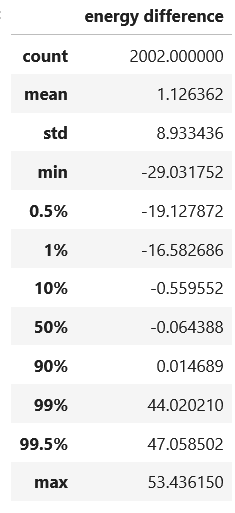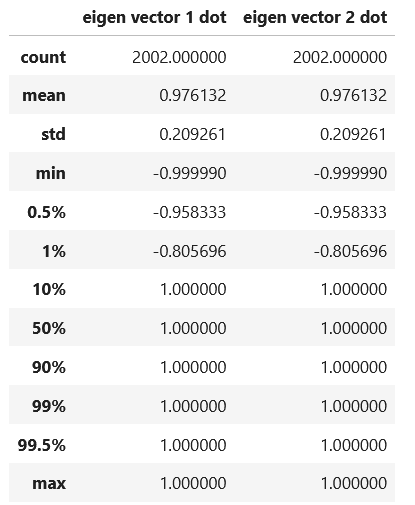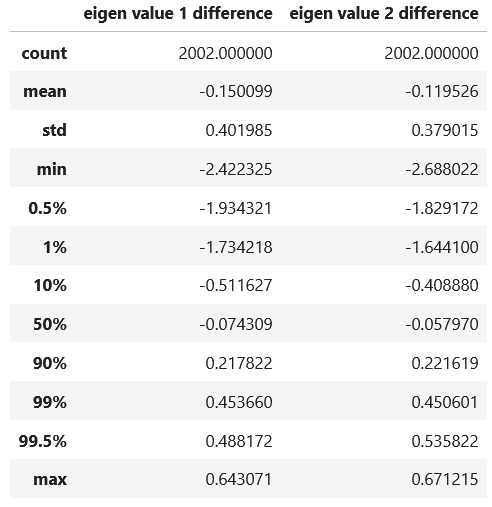

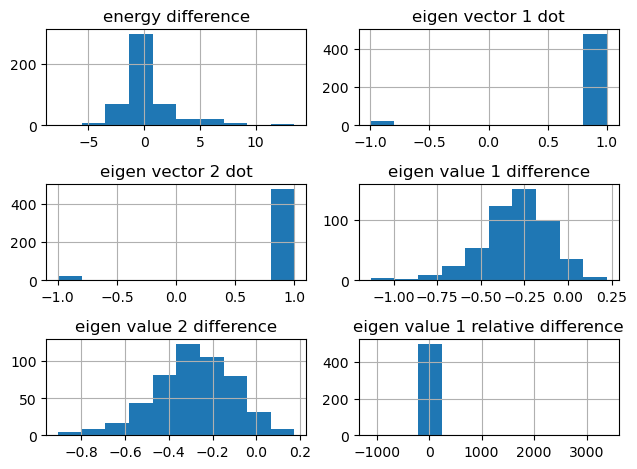

In [36]:
df.hist()
plt.tight_layout()

In [40]:
i,j = (E1-E2).argsort()[[-1,-150]]
i,j

(404, 318)

In [41]:
E1[i],E2[i]

(14.325611274658117, 0.8438748146758177)

In [42]:
Ses_org[i],"corrected",Ses_corrected[i]

(array([[-0.45056516, -0.01482308],
        [-0.01482308, -0.48454323]]),
 'corrected',
 array([[ 0.49302023, -0.15748068],
        [-0.15748068,  0.13203666]]))

In [43]:
np.linalg.eig(Ses_org[i]),"corrected",np.linalg.eig(Ses_corrected[i])

((array([-0.44500756, -0.49010084]),
  array([[ 0.93635095,  0.35106538],
         [-0.35106538,  0.93635095]])),
 'corrected',
 (array([0.55206435, 0.07299254]),
  array([[ 0.93635095,  0.35106538],
         [-0.35106538,  0.93635095]])))

In [44]:
E1[j],E2[j]

(0.6036194965837227, 0.10605052342402015)

In [45]:
Ses_org[j],"corrected",Ses_corrected[j]

(array([[-0.17254967, -0.09249352],
        [-0.09249352, -0.04424023]]),
 'corrected',
 array([[-0.00330276, -0.0478831 ],
        [-0.0478831 ,  0.06312194]]))

In [46]:
np.linalg.eig(Ses_org[j]),"corrected",np.linalg.eig(Ses_corrected[j])

((array([-0.22095995,  0.00417005]),
  array([[-0.88598389,  0.46371602],
         [-0.46371602, -0.88598389]])),
 'corrected',
 (array([-0.02836435,  0.08818352]),
  array([[-0.88598389,  0.46371602],
         [-0.46371602, -0.88598389]])))

Try to recreate the calculation in python

In [47]:
i=i_good

In [48]:
hkg = (np.trace(Ses_org[i])**2)-np.linalg.det(Ses_org[i])
hkg

0.02499620242680474

In [49]:
hkg = (v1.mean_curvature2[i]**2)-v1.gaussian_curvature2[i]
hkg

0.04294586690207172

In [50]:
hkg = hkg if hkg>0 else 0
h_corr = v1.mean_curvature2[i] if hkg>0 else np.sqrt(v1.gaussian_curvature2[i])
hkg, h_corr

(0.04294586690207172, 0.4344833580021617)

In [51]:
factor = np.sqrt( hkg*((Ses_org[i,0,0]-Ses_org[i,1,1])**2+4*(Ses_org[i,0,1]**2)) )

In [52]:
Ses_org[i]

array([[-0.08625433, -0.0044303 ],
       [-0.0044303 , -0.09614493]])

In [53]:
delta = h_corr-(Ses_org[i,0,0]+Ses_org[i,1,1])/2

In [54]:
beta=Ses_org[i,0,1]*( 2*(-hkg)/factor - 1) if factor!=0 else 0
a = -(
    (Ses_org[i,0,0]-Ses_org[i,1,1])*(2*factor+(Ses_org[i,0,0]-Ses_org[i,1,1])**2+4*(Ses_org[i,0,1]**2))
      /( 2*((Ses_org[i,0,0]-Ses_org[i,1,1])**2) + 8*(Ses_org[i,0,1]**2) )
     )

In [55]:
beta2=Ses_org[i,0,1]*( 2*(hkg)/factor - 1) if factor!=0 else 0
a2 = -(
    (Ses_org[i,0,0]-Ses_org[i,1,1])*(-2*factor+(Ses_org[i,0,0]-Ses_org[i,1,1])**2+4*(Ses_org[i,0,1]**2))
      /( 2*((Ses_org[i,0,0]-Ses_org[i,1,1])**2) + 8*(Ses_org[i,0,1]**2) )
     )

In [56]:
a**2+beta**2,a2**2+beta2**2

(0.04574182836990685, 0.04023807261310505)

In [57]:
s1=Ses_org[i]+[[delta+a2,beta2],[beta2,delta-a2]]
s2=Ses_org[i]+[[delta+a,beta],[beta,delta-a]]
print("using delta, a, and beta\n",s1,"\nusing delta, a2, and beta2\n",s2,"\nactual correction in c\n",Ses_corrected[i])

using delta, a, and beta
 [[ 0.58883634 -0.13827879]
 [-0.13827879  0.28013038]] 
using delta, a2, and beta2
 [[0.28013038 0.13827879]
 [0.13827879 0.58883634]] 
actual correction in c
 [[ 0.58883634 -0.13827879]
 [-0.13827879  0.28013038]]


In [58]:
v1.mean_curvature2[i],np.trace(s1)/2,np.trace(s2)/2,np.trace(Ses_corrected[i])/2

(0.4344833580021617,
 0.43448335800216176,
 0.43448335800216176,
 0.43448335800216176)

In [59]:
v1.gaussian_curvature2[i],np.linalg.det(s1),np.linalg.det(s2),np.linalg.det(Ses_corrected[i])

(0.1458299214787629,
 0.14582992147876292,
 0.1458299214787629,
 0.14582992147876292)

### messy handling of the function directly

In [60]:
mats=np.array([[1.1,1],[1,1]])
h,kg = 1,1
a,b,c = ts.ts_double(mats[0,0]),ts.ts_double(mats[0,1]),ts.ts_double(mats[1,1])
ts.error_correction_scheme(ts.pointer(a),ts.pointer(b),ts.pointer(c),h,kg)
mats2=np.array([[a.value,b.value],[b.value,c.value]])
mats, mats2

(array([[1.1, 1. ],
        [1. , 1. ]]),
 array([[1., 0.],
        [0., 1.]]))

In [61]:
"initial h,kg:",np.trace(mats)/2,np.linalg.det(mats),"corrected h,kg:",np.trace(mats2)/2,np.linalg.det(mats2)

('initial h,kg:', 1.05, 0.10000000000000002, 'corrected h,kg:', 1.0, 1.0)

In [62]:
hkg = h**2-kg
hkg2 = (np.trace(mats)**2)/4-np.linalg.det(mats)
hkg

0

In [63]:
factor = np.sqrt( hkg*( (mats[0,0]-mats[1,1])**2+4*(mats[0,1]**2) ) )
factor

0.0

In [64]:
delta = h-(mats[0,0]+mats[1,1])/2
delta

-0.050000000000000044

In [65]:
beta=-mats[0,1] if factor==0 else mats[0,1]*( 2*(-hkg)/factor - 1)
a = -(
    (mats[0,0]-mats[1,1])*(2*factor+(mats[0,0]-mats[1,1])**2+4*(mats[0,1]**2))
      /( 2*((mats[0,0]-mats[1,1])**2) + 8*(mats[0,1]**2) )
     )

In [66]:
beta,a

(-1.0, -0.050000000000000044)

In [67]:
beta=-mats[0,1] if factor==0 else mats[0,1]*( 2*(hkg)/factor - 1)
a = -(
    (mats[0,0]-mats[1,1])*(-2*factor+(mats[0,0]-mats[1,1])**2+4*(mats[0,1]**2))
      /( 2*((mats[0,0]-mats[1,1])**2) + 8*(mats[0,1]**2) )
     )

In [68]:
beta,a

(-1.0, -0.050000000000000044)

In [69]:
mats+[[delta+a,beta],[beta,delta-a]]

array([[1., 0.],
       [0., 1.]])

## Test curvature

Load the file and the vesicle. Push the vesicle into the PyVtu

In [71]:
fileloc = list(sorted(test_folder.glob('timestep*')))[-1]#[-1]

In [72]:
fileloc

PosixPath('/home/toriy/yoav/sim/test/attempt1/timestep_000024.vtu')

In [73]:
vesicle = ts.parseDump(fileloc)

In [74]:
v = PyVtu(fileloc)
v2 = PyVtu(fileloc) # we will place here the values from vesicle

In [75]:
def normbnorm(b):
    n1 = np.array((b.vtx1.contents.nx,b.vtx1.contents.ny,b.vtx1.contents.nz))
    n2 = np.array((b.vtx2.contents.nx,b.vtx2.contents.ny,b.vtx2.contents.nz))
    n = n1+n2
    return n/np.linalg.norm(n)

In [92]:
def field_from(vesicle,field=None,lst='vlist'):
    try:
        return np.array([v.__getattribute__(field) for v in ts.iter_xlist(vesicle,lst)])
    except AttributeError:
        return None
def vector_field_from(vesicle,fields,lst='vlist'):
    try:
        return np.array([tuple(v.__getattribute__(field) for field in fields) for v in ts.iter_xlist(vesicle,lst)])
    except AttributeError:
        return None

def array_field_from(vesicle,field,lst='vlist'):
    try:
        return np.array([v.__getattribute__(field)[:] for v in ts.iter_xlist(vesicle,lst)])
    except AttributeError:
        return None
    
vertex_fields = [x[0] for x in ts.ts_vertex._fields_]
bond_fields = [x[0] for x in ts.ts_bond._fields_]
triangle_fields = [x[0] for x in ts.ts_triangle._fields_]
blen = vesicle.contents.blist.contents.n
tlen = vesicle.contents.tlist.contents.n

def replace_pyvtu_values_from_vesicle(v,vesicle):
    """Replace the values the PyVtu arrays with values from the wrapper."""
    v.add_array('pos',vector_field_from(vesicle,('x','y','z')))
    v.add_array('neigh_no',field_from(vesicle,'neigh_no'))
    v.add_array('c0',field_from(vesicle,'c'))
    v.add_array('e',field_from(vesicle,'energy'))
    # newer version stuff (can fail but who cares?)
    v.add_array('w',field_from(vesicle,'w'))
    v.add_array('f0',field_from(vesicle,'f'))
    v.add_array('normal',vector_field_from(vesicle,['nx','ny','nz']))
    v.add_array('force',vector_field_from(vesicle,['fx','fy','fz']))
    v.add_array('e',field_from(vesicle,'energy'))
    if 'xnorm' in triangle_fields:
        v.add_array('face_normal',np.concatenate((np.zeros((blen,3)),vector_field_from(vesicle,('xnorm','ynorm','znorm'),'tlist'))),parent='CellData')
    v.add_array('ad_w',field_from(vesicle,'ad_w'))
    if 'type' in vertex_fields:
        v.add_array('type', np.array([ts.byte_to_int(v.type) for v in ts.iter_xlist(vesicle)]))
    v.add_array('k',field_from(vesicle,'k'))
    v.add_array('k2',field_from(vesicle,'k2'))
    v.add_array('area',field_from(vesicle,'area'))
    v.add_array('gaussian_curvature',field_from(vesicle,'gaussian_curvature'))
    v.add_array('mean_curvature',field_from(vesicle,'mean_curvature'))
    v.add_array('gaussian_curvature',field_from(vesicle,'gaussian_curvature'))
    v.add_array('director',vector_field_from(vesicle,('dx','dy','dz')))
    v.add_array('mean_curvature2',field_from(vesicle,'mean_curvature2'))
    v.add_array('gaussian_curvature2',field_from(vesicle,'gaussian_curvature2'))
    v.add_array('eig0',array_field_from(vesicle,'eig0'))
    v.add_array('eig1',array_field_from(vesicle,'eig1'))
    v.add_array('eig2',array_field_from(vesicle,'eig2'))
    v.add_array('eigenvalue_0',field_from(vesicle,'eig_v0'))
    v.add_array('eigenvalue_1',field_from(vesicle,'eig_v1'))
    v.add_array('eigenvalue_2',field_from(vesicle,'eig_v2'))

    if 'xcirc' in triangle_fields:
        v.add_array('circumcenter',np.concatenate((np.zeros((blen,3)),vector_field_from(vesicle,('xcirc','ycirc','zcirc'),'tlist'))),parent='CellData')
    if 'S' in vertex_fields:
        v.add_array('dSd',np.array([x.S[0] for x in ts.iter_xlist(vesicle)]))
        v.add_array('dSt',np.array([x.S[1] for x in ts.iter_xlist(vesicle)]))
        v.add_array('tSd',np.array([x.S[2] for x in ts.iter_xlist(vesicle)]))
        v.add_array('tSt',np.array([x.S[3] for x in ts.iter_xlist(vesicle)]))
    v.add_array('tangent',np.cross(v.normal,v.director))
    
    v.add_array('mean_curvature3',v.mean_curvature+0)
    v.add_array('gaussian_curvature3',v.gaussian_curvature+0)
    v.add_array('normal3',v.normal+0)
    for i, vtx in enumerate(ts.iter_xlist(vesicle)):
        vtx_copy=ts.ts_vertex(**{field:vtx.__getattribute__(field) for field in vertex_fields})
        ts.tensor_curvature_energy2(vesicle,ts.pointer(vtx_copy))
        v.mean_curvature3[i]=vtx_copy.mean_curvature
        v.gaussian_curvature3[i]=vtx_copy.gaussian_curvature
        v.normal3[i]=vtx_copy.nx,vtx_copy.ny,vtx_copy.nz
    

In [87]:
try:
    replace_pyvtu_values_from_vesicle(v2,vesicle)
except AttributeError as e:
    print(f'partial replacement: {e}')

Update and write vtu with all the new stuff

In [88]:
v2.update_all()
v2.write_vtu(str(v2.path).replace('timestep','pystep'))

We can view this new vtu in paraview.

## Mess about

Check normals are okay

In [93]:
def normalize(x,**kwargs):
    return x/(np.linalg.norm(x,**kwargs))

In [99]:
def perp_bisect(v2,i):
    tposi = v2.pos[v2.tlist[i]]
    circ = v2.circumcenter[blen+i]
    norm = v2.face_normal[blen+i]
    l0,l1,l2 = tposi[1]- tposi[0], tposi[0]- tposi[2], tposi[2]- tposi[1]
    perps = l0/np.linalg.norm(l0),l1/np.linalg.norm(l1),l2/np.linalg.norm(l2)
    perps = [normalize(np.cross(norm,p)) for p in perps]
    m0,m1,m2 = ( tposi[1]+ tposi[0])/2, (tposi[0]+ tposi[2])/2,( tposi[2]+ tposi[1])/2
    return (m0,m1,m2,*perps)

In [100]:
out = []
out2 = []
for i in range(v.tlist.shape[0]):
    m0,m1,m2,p0,p1,p2 = perp_bisect(v2,i)
    circ = v2.circumcenter[blen+i]
    out.append([normalize(m0-circ)@p0,normalize(m1-circ)@p1,normalize(m2-circ)@p2])
    out2.append((v2.pos[v2.tlist[i]]-v2.pos[v2.tlist[i]][[1,2,0]])@v2.face_normal[blen+i])
    
out3 = []
for i in v.indices:
    out3.append(v.director[i]@v.normal[i])

bads = np.where(~np.isclose(out,-1))[0]
bads2 = np.where(~np.isclose(out2,0))[0]
bads3 = np.where(~np.isclose(out3,0))[0]
badness=False
if bads.size>0:
    print(bads)
    print("1st example:",out[bads[0]])
    badness=True
if bads2.size>0:
    print(bads2)
    print("1st example:",out2[bads2[0]])
    badness=True
if bads3.size>0:
    print(bads3)
    print("1st example:", out3[bads3[0]])
    badness=True
if not badness:
    print('all good')

[  7  10  19  30  50  53  77  79  83  92 121 122 124 145 149 173 179 193
 202 205 217 220 221 224 227 238 239 244 268 271 274 279 281 285 302 319
 332 348 349 354 357 358 365 372 379 385 400 412 423 424 438 447 448 457
 465 473 483 487 495 521 526 531 536 539 544 585 589 604 612 619 620 622
 637 651 676 678 681 692 710 711 720 724 726 733 736 737 744 771 795 800
 801 811 815 816 825 832 844 845 851 865 868 873 886 904 917 932 948 954
 984 991]
1st example: [1.0, -1.0000000000000002, -1.0000000000000002]


### Print triangles

Notice i is the triangle index!

In [101]:
with_bad_vtx = problematic_values[v2.tlist].any(axis=1)
gen=(x for x in np.arange(len(v2.tlist))[:]) # .tlist))[with_bad_vtx])
i=next(gen)

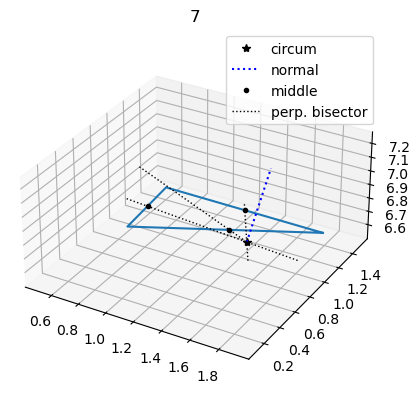

In [111]:
##%matplotlib widget

mp = perp_bisect(v2,i)
res = np.array(((v.pos[v.tlist[i]]-v.pos[v.tlist[i]][[1,2,0]])@v.face_normal[blen+i],
               (v2.pos[v2.tlist[i]]-v2.pos[v2.tlist[i]][[1,2,0]])@v2.face_normal[blen+i],
               [mp[3],mp[4],mp[5]]@v.face_normal[blen+i]))
if (np.abs(res)>1e-15).any():
    print("perp. in vtu: ", res[0])
    print("perp. in loaded vesicle: ", res[1])
    print("check perp. bisectors are perpendicular: ",res[2])

ax = plt.figure().add_subplot(projection='3d')
tposi = v2.pos[v2.tlist[i]]
ax.plot(*np.array([tposi[[0,1,2,0]]]).T)
ax.plot(*v2.circumcenter[blen+i],'k*',label='circum')
ax.plot(*np.array((v2.circumcenter[blen+i], 
                   v2.circumcenter[blen+i]-0.5*v2.face_normal[blen+i])).T,
        'b:',label='normal')
ax.plot(*mp[0],'k.',label='middle')
ax.plot(*mp[1],'k.')
ax.plot(*mp[2],'k.')
ax.plot(*np.array((mp[0]+1*mp[3],mp[0]-0.15*mp[3])).T,'k:',linewidth=1,label='perp. bisector')
ax.plot(*np.array((mp[1]+1*mp[4],mp[1]-0.15*mp[4])).T,'k:',linewidth=1)
ax.plot(*np.array((mp[2]+1*mp[5],mp[2]-0.15*mp[5])).T,'k:',linewidth=1)
ax.set_aspect('equal')
ax.set_title(str(i))
ax.legend()
i=next(gen)

In [ ]:
## %matplotlib inline

### Figure out what's going on in the curvature

In [112]:
df = pd.DataFrame({'H isotropic': v2.mean_curvature2, 'KG isotropic': v2.gaussian_curvature2,
                   'H anisotropic': v2.mean_curvature, 'KG anisotropic': v2.gaussian_curvature,
                   'H lerp': v2.mean_curvature3,'KG lerp': v2.gaussian_curvature3
                  })
df.describe()

,H isotropic,KG isotropic,H anisotropic,KG anisotropic,H lerp,KG lerp
count,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000
mean,0.153193,0.019479,0.154401,0.019479,0.001463,-0.000119
std,0.117020,0.040308,0.118132,0.040308,0.014101,0.000799
min,-0.151661,-0.067019,-0.151661,-0.067019,-0.066249,-0.010255
25%,0.065434,-0.005139,0.065653,-0.005139,-0.000136,-0.000070
50%,0.154612,0.010188,0.154867,0.010188,0.000757,-0.000015
75%,0.229759,0.036361,0.230125,0.036361,0.004558,-0.000001
max,0.561668,0.232513,0.561668,0.232513,0.068595,0.002603


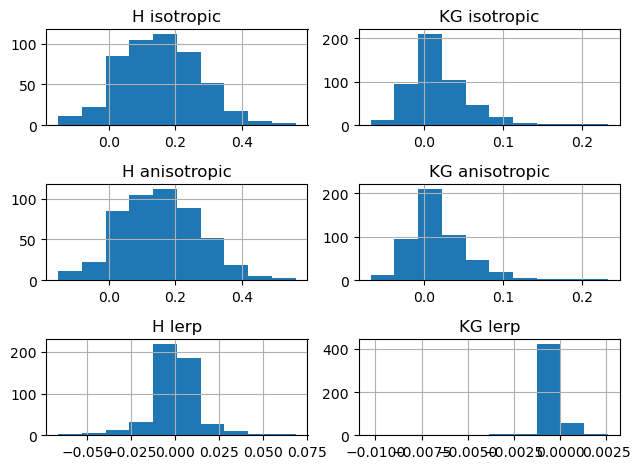

In [114]:
df.hist()
plt.tight_layout()

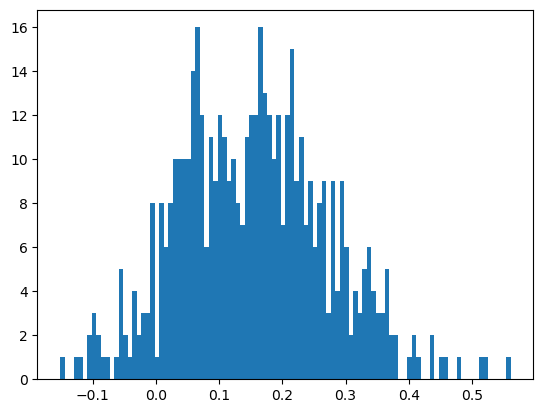

In [115]:
fig=plt.figure()
plt.hist(v2.mean_curvature,bins=100)
plt.show()

In [119]:
S=vtu.reconstruct_shape_operator(v2)

In [120]:
g=np.stack((v2.eig0,v2.eig1,v2.eig2),axis=1)

In [121]:
np.einsum("ni,ni->n",v2.eig0,v2.eig2).mean()

3.29608529232673e-18

In [122]:
vtu.reconstruct_shape_operator(v2)[0]

array([[ 0.31817876, -0.04661724, -0.12750666],
       [-0.04661724,  0.33859002, -0.1026122 ],
       [-0.12750666, -0.1026122 ,  0.09544259]])

In [123]:
vtu.reconstruct_shape_operator(v2)[0]

array([[ 0.31817876, -0.04661724, -0.12750666],
       [-0.04661724,  0.33859002, -0.1026122 ],
       [-0.12750666, -0.1026122 ,  0.09544259]])

In [118]:
np.einsum("nij,nkj->nik",g,g)

NameError: name 'g' is not defined

In [ ]:
s00 = np.einsum("ni,nij,nj->n",v2.director,S,v2.director)
s11 = np.einsum("ni,nij,nj->n",v2.tangent,S,v2.tangent)
s01 = np.einsum("ni,nij,nj->n",v2.director,S,v2.tangent)
s10 = np.einsum("ni,nij,nj->n",v2.tangent,S,v2.director)

In [ ]:
S_diag=np.zeros((v2.indices.shape[0],2,2))
S2=np.zeros((v2.indices.shape[0],2,2))
S_diag[:,0,0]=s00
S_diag[:,1,1]=s11
S2[:,0,0]=s00
S2[:,0,1]=s01
S2[:,1,0]=s10
S2[:,1,1]=s11

In [ ]:
np.trace(S_diag,axis1=1,axis2=2)

In [ ]:
np.trace(S2,axis1=1,axis2=2)

In [ ]:
v2.mean_curvature

In [ ]:
v2.mean_curvature2

In [ ]:
vertices = list(iter_xlist(vesicle,as_pointer=True))

In [ ]:
for i in v.indices[-10:]:
    print(ts.adhesion_geometry_distance(vesicle,vertices[i]))

In [ ]:
vesicle.contents.tape.contents.adhesion_cutoff

In [ ]:
vesicle.contents.tape.contents.mcsweeps

In [ ]:
vesicle.contents.vlist.contents.vtx[2000].contents.z

In [ ]:
# ts.run_simulation(vesicle,1000,0,175,160)

In [ ]:
adhesion_dist = np.array([ts.adhesion_geometry_distance(vesicle,vtx) for vtx in vertices])

In [ ]:
adhesion_dist

In [ ]:
class MongeGauge:

    def __init__(self,x,y,c0,r,z0):
        """Compute monge gauge for h(x,y) = z0+r*cos(x/c0)*cos(y/c0)"""
        self.x=x
        self.y=y
        self.z0=z0
        self.r=r
        self.c0=c0
        self.R = r*np.cos(x/c0)*np.cos(y/c0)+z0
        self.z=self.R
        self.Rx, self.Ry = -r*np.sin(x/c0)*np.cos(y/c0)/c0, -r*np.cos(x/c0)*np.sin(y/c0)/c0
        self.Rxx = r*np.cos(x/c0)*np.cos(y/c0)/(-c0**2)
        self.Ryy = r*np.cos(x/c0)*np.cos(y/c0)/(-c0**2)
        self.Rxy = r*np.sin(x/c0)*np.sin(y/c0)/(c0**2)
        self.J = np.array([[1,0,self.Rx],[0,1,self.Ry],[0,0,1]])
        self.e1,self.e2,self.e3 = self.J
        self.g_ab = np.array([[1+self.Rx**2,self.Rx*self.Ry],
                              [self.Rx*self.Ry,1+self.Ry**2]])
        self.g = 1+self.Rx**2+self.Ry**2
        self.sqrtg = (self.g**0.5)
        self.gab = np.array([[1+self.Ry**2,-self.Rx*self.Ry],
                             [-self.Rx*self.Ry,1+self.Rx**2]])/self.g
        self.n = np.array([-self.Rx,-self.Ry,1])/self.sqrtg
        self.K_ab = np.array([[self.Rxx,self.Rxy],
                              [self.Rxy,self.Ryy]])/self.sqrtg
        self.Sa_b = self.K_ab@self.gab
        self.w,self.v = np.linalg.eig(self.Sa_b)
        self.vxyz = self.v.T@self.J[:2]
        self.H, self.KG = self.Sa_b.trace()/2, np.linalg.det(self.Sa_b)
        self.xyzFromab = np.array([self.e1,self.e2])
        self.Jinv = np.linalg.inv(self.J)



In [ ]:
def expected_curvature(vesicle,vtx):
    r = vesicle.contents.tape.contents.adhesion_radius
    c0 = vesicle.contents.tape.contents.adhesion_scale
    z0 = vesicle.contents.tape.contents.adhesion_z
    x,y,z = vtx.contents.x, vtx.contents.y, vtx.contents.z
    # Monge Gauge
    return MongeGauge(x,y,c0,r,z0)
    

In [ ]:
r = vesicle.contents.tape.contents.adhesion_radius
c0 = vesicle.contents.tape.contents.adhesion_scale
z0 = vesicle.contents.tape.contents.adhesion_z

In [ ]:
def press_vertices_to_shape(vesicle):
    r = vesicle.contents.tape.contents.adhesion_radius
    c0 = vesicle.contents.tape.contents.adhesion_scale
    z0 = vesicle.contents.tape.contents.adhesion_z
    for vtx in iter_xlist(vesicle3,as_pointer=True):
        if dz:=ts.adhesion_geometry_distance(vesicle,vtx)<0.5:
            vtx.contents.z = z0+r*np.cos(vtx.contents.x/c0)*np.cos(vtx.contents.y/c0)
    ts.init_normal_vectors(vesicle.contents.tlist)
    ts.sweep_vertex_curvature_energy(vesicle)


In [ ]:
v3 = PyVtu(v2.path)
vesicle3 = ts.parseDump(v3.path)
press_vertices_to_shape(vesicle3)
replace_pyvtu_values_from_vesicle(v3,vesicle3)

In [ ]:
adhesion_dist2 = np.array([ts.adhesion_geometry_distance(vesicle3,vtx) for vtx in iter_xlist(vesicle3,as_pointer=True)])
adhesion_dist2[-20:]

In [ ]:
v3.update_all()
v3.write_vtu(str(v3.path).replace('timestep','flattened_pystep'))

In [ ]:
Svs = vtu.reconstruct_shape_operator(v3)
gs = np.stack((v3.eig0,v3.eig1,v3.eig2),axis=1)

In [ ]:
i=1950

In [ ]:
i+=1

In [ ]:
mg=expected_curvature(vesicle,vertices[i])

In [ ]:
2*mg.H, mg.KG

In [ ]:
('tensor:',v3.mean_curvature[i],v3.gaussian_curvature[i]),('debug: ',v3.mean_curvature2[i],v3.gaussian_curvature2[i])

In [ ]:
gs[i], Svs[i]

In [ ]:
Sx_y=np.einsum("ab,bi,aj->ij",mg.Sa_b,mg.J[:2,:],mg.J[:2,:])
Sx_y

In [ ]:
mg.w,mg.vxyz

In [ ]:
v3.eigenvalue_0[i],v3.eigenvalue_1[i],v3.eig0[i],v3.eig1[i]

In [ ]:
def square_comp(x,y,z,v0,v1,v2,e0,e1,e2):
    xy=np.linspace(-1,1,10)
    XY=np.array(np.meshgrid(xy,xy))
    E0, E1 = np.einsum("ix,xnm->inm",np.array((e0,e1))[:,:2],XY)
    E2 = 0.5*v0*E0**2 + 0.5*v2*E1**2
    X,Y,Z = np.einsum("xi,inm->xnm",np.linalg.inv(np.array((e0,e1,e2))),np.array((E0,E1,E2)))
    return X+x,Y+y,Z+z
    

In [ ]:
%matplotlib widget
ax = plt.figure().add_subplot(projection='3d')
dist = ((v3.pos-v3.pos[i])**2).sum(axis=1)**0.5
in_dist = dist<5
x, y = np.linspace(tuple(v3.pos[in_dist,:2].min(axis=0)),tuple(v3.pos[in_dist,:2].max(axis=0)),20).T
X,Y = np.meshgrid(x,y)
Z = z0+r*np.cos(X/c0)*np.cos(Y/c0)
ax.plot_wireframe(X,Y,Z,linewidths=0.5)
X,Y,Z = square_comp(*v3.pos[i],v3.eigenvalue_0[i],v3.eigenvalue_1[i],v3.eigenvalue_2[i],v3.eig0[i],v3.eig1[i],v3.eig2[i])
ax.plot_wireframe(X,Y,Z,linewidths=0.5,color='g')
X,Y,Z = square_comp(*v3.pos[i],*mg.w,0,*mg.vxyz,mg.n)
ax.plot_wireframe(X,Y,Z,linewidths=0.5,color='r')
ax.plot(*v3.pos[in_dist].T,'.k',markersize=1)
ax.plot(*v3.pos[i],'*')
ax.plot(*v3.pos[v3.get_ordered_neighbors(v3.indices[i])].T,'*')
ax.set_aspect('equal')
ax.set_title(f'{i}')

In [ ]:
plt.close()

# and now for something completely different

In [ ]:
def plotMySurf(axe3D, *, points=None, p_dict=None, bonds=None, b_dict=None,
               triangles=None, t_dict=None, reaspect=None, **fmt_dict):
    """Plot a surface with points and bonds.

    points: nx3
    p_dict: {color: 'k', 'linestyle':'None', 'marker'='.', 'linewidth': 0.4}
    bonds: mx2
    b_dict: {'color': 'k', 'linestyle': '-',
             'marker': 'None', 'linewidth': 0.25}
    """
    if points is not None:
        if p_dict is None:
            p_dict = {'color': 'k',
                      'linestyle': 'None', 'marker': '.',
                      'linewidth': 0.2, }#'markersize': 2}
        p_dict.update(fmt_dict)
        x, y, z = np.vstack((points, np.ones(3)*np.nan)).T
        axe3D.scatter3D(x[:-1], y[:-1], z[:-1], **p_dict)
        if reaspect:
            reaspectAxe(axe3D, points)
    if bonds is not None:
        edges = np.hstack((bonds,
                           np.ones((bonds.shape[0], 1), dtype=int)*(len(x)-1))
                          ).flatten()
        if b_dict is None:
            b_dict = {'color': 'k', 'linestyle': '-',
                      'marker': 'None', 'linewidth': 0.25}
        b_dict.update(fmt_dict)
        if type(b_dict['color']) is np.ndarray:
            if b_dict['color'].size>4.:
                b_dict['color']=b_dict['color'].mean(axis=0)
        xen, yen, zen = x[edges], y[edges], z[edges]
        axe3D.plot3D(xen, yen, zen, **b_dict)

In [ ]:
def color_for(_type, lbl=None):
    """Color function for clusters."""
    c_bare = (0.9, 0.9, 0.9, 1.0)
    c_conv = plt.cm.tab20b(13)
    c_conc = plt.cm.tab20c(1)
    try:
        c = (
             (_type[:, np.newaxis] == 5)*c_conc
             + (_type[:, np.newaxis] == 47)*c_conv
             + (_type[:, np.newaxis] == 4)*c_bare
            )
    except (IndexError, TypeError):
        c = {5: c_conc, 47: c_conv}.get(_type, c_bare)
    return c


In [ ]:
def fit_coolwarm(array,minval=None,maxval=None):
    if minval is None:
        minval=min(array)
    if maxval is None:
        maxval=max(array)
    if minval==maxval:
        return plt.cm.coolwarm(array)
    carray = (array-minval)/(maxval-minval)
    return plt.cm.coolwarm(carray)

In [ ]:
color2 = fit_coolwarm(v3.mean_curvature,-1,1)
color2

In [ ]:
color2[v3.blist].mean(axis=1)

In [ ]:
fig = plt.figure()
axe = fig.add_subplot(projection='3d')
plotMySurf(axe,points=v3.pos,p_dict={'color': color2,'s':0.5},
           bonds=v.blist,b_dict={'color': color2[v3.blist].mean(axis=1)})

In [ ]:
fig = plt.figure()
axe = fig.add_subplot(projection='3d')
axe.plot(*v3.pos.T,'.',color='k',markersize=0.5)

In [ ]:
def refine_mesh_once(v):
    """Create x,y,z and tlist of a refined mesh.

    Every bond in the original mesh is now another vertex with index
    of number original vertices + number of the original bond
    """
    x,y,z = v.pos.T
    tlist = v.tlist
    blist = v.blist
    nvtx = len(x)
    nb = len(blist)
    nt = len(tlist)
    x2,y2,z2 = np.zeros((3,nvtx+nb))
    x2[:nvtx],y2[:nvtx],z2[:nvtx] = x,y,z
    x2[nvtx:],y2[nvtx:],z2[nvtx:] = v.pos[v.blist].mean(axis=1).T
    tlist2 = np.zeros((4*nt,3),dtype=int)
    # blist2 = np.zeros((3*nt//2,2),dtype=int)
    for i,t in enumerate(tlist):
        a,b,c = t
        ab=nvtx+np.where((blist==(a,b)).all(1)|(blist==(b,a)).all(1))[0][0]
        bc=nvtx+np.where((blist==(b,c)).all(1)|(blist==(c,b)).all(1))[0][0]
        ca=nvtx+np.where((blist==(c,a)).all(1)|(blist==(a,c)).all(1))[0][0]
        tlist2[4*i:4*(i+1),:]=((a,ab,ca),(b,bc,ab),(c,ca,bc),(ab,bc,ca))
    return x2,y2,z2,tlist2


In [ ]:
x2,y2,z2,tlist2 = refine_mesh_once(v2)

In [ ]:
types = np.concatenate((v2.type,v2.type[v2.blist].sum(axis=1)/2))
c_tri = fit_coolwarm(types[tlist2].sum(axis=1)/3)#,4-47,47)

In [ ]:
poly3=Poly3DCollection(verts=np.stack((x2[tlist2],y2[tlist2],z2[tlist2]),axis=-1),
                       facecolor=c_tri,edgecolor='k',linewidth=0.1)
fig = plt.figure()
axe = fig.add_subplot(projection='3d')
axe.add_collection3d(poly3)
axe.auto_scale_xyz(x2,y2,z2)

In [ ]:
tri=plt.matplotlib.tri.Triangulation(*v.pos[:,:2].T)
ref = plt.matplotlib.tri.UniformTriRefiner(tri)
tri2, z2=ref.refine_field(v.pos[:,2])
tri3, c2=ref.refine_field(v.c0)

In [ ]:
color_ref = plt.cm.coolwarm(np.array((*c2,-1,1)))[:-2]

In [ ]:
triangles = tri2.get_masked_triangles()
xt = tri2.x[triangles]
yt = tri2.y[triangles]
zt = z2[triangles]
verts = np.stack((xt, yt, zt), axis=-1)
cs = color_ref[triangles].mean(axis=1)

In [ ]:
poly3=Poly3DCollection(verts=verts,facecolor=cs)
fig = plt.figure()
axe = fig.add_subplot(projection='3d')
axe.add_collection3d(poly3)
axe.auto_scale_xyz(xt,yt,zt)

In [ ]:
tricol=color2[v3.tlist].mean(axis=1)

In [ ]:
v.tlist

In [ ]:
tricol

In [ ]:
poly3=Poly3DCollection(verts=v.pos[v.tlist],facecolor=tricol)

In [ ]:
poly3

In [ ]:
v.pos[v.tlist]

In [ ]:
fig = plt.figure()
axe = fig.add_subplot(projection='3d')
axe.add_collection3d(poly3)
axe.auto_scale_xyz(*v3.pos.T)